In [50]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: dawg-python>=0.7.1 in d:\anaconda\lib\site-packages (from pymorphy2) (0.7.2)



In [51]:
pip install stop_words

Note: you may need to restart the kernel to use updated packages.


In [52]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [53]:
import json
import re
import string
import pymorphy2
import stop_words
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem.snowball import RussianStemmer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [54]:
from yellowbrick.classifier import ClassPredictionError

In [55]:
categories = ['lico', 'glaza', 'guby', 'brovi', 'nogti', 'kisti']

In [56]:
article_filename = "practis.json" 

In [57]:
news = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        news.append(json.loads(line))

data = pd.DataFrame(news)
data

,Title,Category,Tags,Text,Link
0,КОНТУРНЫЙ КАРАНДАШ ДЛЯ БРОВЕЙ,brovi,карандаш для бровей женский Германия,Аккуратный «макияж без макияжа» или выразитель...,https://goldapple.ru/10899-19760345970-fill-fi...
1,Фиксер для бровей,brovi,гель для бровей унисекс Нидерланды,"Привет, я буду персональным ассистентом твоих ...",https://goldapple.ru/100059-19000005509-get-a-...
2,Механический карандаш для бровей,brovi,карандаш для бровей унисекс Нидерланды,Поприветствуйте своего лучшего помощника в пог...,https://goldapple.ru/100059-19000005516-big-ba...
3,Тени для бровей,brovi,палетки для бровей женский США,Три универсальных матовых оттенка для бровей –...,https://goldapple.ru/58274000001-brow-trio
4,Гель для бровей,brovi,гель для бровей женский DE,Гель для бровей brow like a boss легко и аккур...,https://goldapple.ru/10553-19000083016-like-a-...
...,...,...,...,...,...
5722,Кисть,kisti,кисти для глаз унисекс США,Двусторонняя кисть: с одной стороны - плоская ...,https://goldapple.ru/19000036764-eye-liner-bro...
5723,Кисть,kisti,кисти для глаз унисекс US,Небольшая скошенная кисть для нанесения и раст...,https://goldapple.ru/19000036763-eye-contour-b...
5724,Кисть,kisti,кисти для лица унисекс США,Кисть для нанесения румян. Ворс: натурон.,https://goldapple.ru/19000036762-dome-brush
5725,Кисть,kisti,кисти для глаз унисекс США,"Маленькая кисть для глаз (ресничный контур, по...",https://goldapple.ru/19000036761-detail-brush


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5727 entries, 0 to 5726
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     5727 non-null   object
 1   Category  5727 non-null   object
 2   Tags      5727 non-null   object
 3   Text      5727 non-null   object
 4   Link      5727 non-null   object
dtypes: object(5)
memory usage: 223.8+ KB


In [59]:
data['Category'].value_counts()

lico     976
glaza    975
guby     973
nogti    963
brovi    960
kisti    880
Name: Category, dtype: int64

In [60]:
data.shape

(5727, 5)

In [61]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [62]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text) for text in data["Text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)' , '', text) for text in corpus] # удаление неполных ссылок

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub('', text) for text in corpus] # убираем пунктуацию

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub('', text) for text in corpus] # убираем цифры

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +' , ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

In [63]:
morph = pymorphy2.MorphAnalyzer()

In [64]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(corpus):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
        
print(len(corpus_tokens), len(inds_to_drop))

5727 0


In [65]:
stemmer = RussianStemmer()

In [66]:
corpus_tokens_stem = []

for i, tokens in enumerate(corpus_tokens):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
    
print(len(corpus_tokens_stem))

5727


In [67]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem]) # массив числа основ токенов, оставшихся в статьях
print(diffs.min()) # минимум основ (нормализованных токенов) = 10

1


In [68]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem]) # массив числа основ токенов, оставшихся в статьях
print(len(diffs))

5727


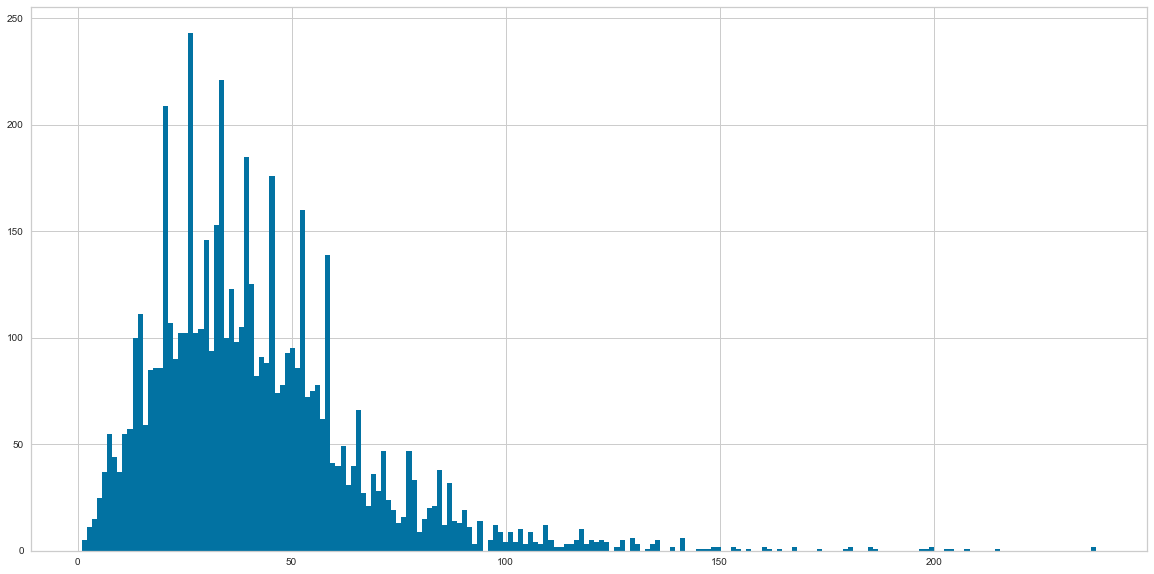

In [69]:
plt.figure(figsize=(20, 10))
plt.hist(diffs, bins=200)
plt.grid(True)

In [70]:
vocab = np.unique(np.concatenate(corpus_tokens_stem).flatten()).tolist()
print(len(vocab))


7373


In [71]:
dataset = []
for i in range(len(corpus_tokens_stem)):
    dataset.append([' '.join(corpus_tokens_stem[i]), data["Category"][i]])
dataset = pd.DataFrame(dataset, columns=["Text", "Category"])

In [72]:
dataset

,Text,Category
0,аккуратн макияж макияж выразительн образ акцен...,brovi
1,привет персональн ассистент тво бров тво бров ...,brovi
2,поприветств лучш помощник погон сам классн бро...,brovi
3,универсальн матов оттенк бров компактн упаковк...,brovi
4,гел бров легк аккуратн нанос благодар скошен щ...,brovi
...,...,...
5722,двусторон кист сторон плоск ровн срез маленьк ...,kisti
5723,небольш скошен кист нанесен растушевк тен удоб...,kisti
5724,кист нанесен румя ворс,kisti
5725,маленьк кист глаз ресничн контур подводк губ р...,kisti


In [73]:
data_train, data_test = train_test_split(dataset, test_size=0.1)
print(len(data_train), len(data_test))

5154 573


In [74]:
data_train.Category.value_counts()

nogti    882
brovi    871
lico     870
guby     869
glaza    865
kisti    797
Name: Category, dtype: int64

In [75]:
vectorizer = TfidfVectorizer(vocabulary=vocab)
vectorizer.fit(dataset)

TfidfVectorizer(vocabulary=['а', 'аа', 'аббревиатур', 'абиссинск', 'абраз',
                            'абразив', 'абразивн', 'абрикос', 'абрикосов',
                            'абсолют', 'абсолютн', 'абсорбент', 'абсорбир',
                            'абсорбирующ', 'абсорбц', 'авитаминоз', 'авокад',
                            'австрал', 'австралийск', 'австралийц', 'австрийск',
                            'автоклав', 'автомат', 'автоматическ', 'автор',
                            'авторитет', 'авторск', 'агав', 'агент', 'агентств', ...])

In [76]:
data_train_vect = vectorizer.transform(data_train["Text"])
data_train_cat = data_train["Category"]
data_test_vect = vectorizer.transform(data_test["Text"])
data_test_cat = data_test["Category"]

In [77]:
#Наивный байесовский классификатор

In [78]:
parameters_nb = {
    "alpha": [0.00001, 0.0001, 0.01, 1, 10] 
}

gs_nb = GridSearchCV(
    MultinomialNB(),
    parameters_nb,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_nb_res = gs_nb.fit(data_train_vect, data_train_cat)
pred_nb = gs_nb_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_nb))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
              precision    recall  f1-score   support

       brovi       0.89      0.90      0.89        89
       glaza       0.95      0.95      0.95       110
        guby       0.97      0.97      0.97       104
       kisti       0.95      0.90      0.93        83
        lico       0.93      0.97      0.95       106
       nogti       1.00      0.98      0.99        81

    accuracy                           0.95       573
   macro avg       0.95      0.95      0.95       573
weighted avg       0.95      0.95      0.95       573



In [79]:
#KNN (K Ближайших Соседей)

In [80]:
parameters_knn = { 
    "n_neighbors": [2, 5, 10, 15, 30, 50, 100],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan"]
}

gs_knn = GridSearchCV( 
    KNeighborsClassifier(),
    parameters_knn,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_knn_res = gs_knn.fit(data_train_vect, data_train_cat) 
pred_knn = gs_knn_res.best_estimator_.predict(data_test_vect) 
print(metrics.classification_report(data_test_cat, pred_knn)) 

Fitting 3 folds for each of 28 candidates, totalling 84 fits
              precision    recall  f1-score   support

       brovi       0.97      0.93      0.95        89
       glaza       0.92      0.95      0.94       110
        guby       0.95      0.96      0.96       104
       kisti       0.98      0.98      0.98        83
        lico       0.95      0.95      0.95       106
       nogti       0.99      0.96      0.97        81

    accuracy                           0.96       573
   macro avg       0.96      0.96      0.96       573
weighted avg       0.96      0.96      0.96       573



In [81]:
#SGD (Стохастический Градиентный Спуск)

In [82]:
parameters_sgd = {
    "penalty": ["elasticnet", "l2", "l1"],
    "alpha": [0.0001, 0.01, 0.1, 0.5, 1, 10,50],
    "max_iter": [100, 500, 1000, 2000],
    "learning_rate": ["optimal", "invscaling", "adaptive"],
    "eta0": [1, 10]
}

gs_sgd = GridSearchCV(
    SGDClassifier(),
    parameters_sgd,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_sgd_res = gs_sgd.fit(data_train_vect, data_train_cat)
pred_sgd = gs_sgd_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_sgd))

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
              precision    recall  f1-score   support

       brovi       0.95      0.92      0.94        89
       glaza       0.96      0.98      0.97       110
        guby       0.97      0.96      0.97       104
       kisti       0.95      0.94      0.95        83
        lico       0.96      0.98      0.97       106
       nogti       0.98      0.99      0.98        81

    accuracy                           0.96       573
   macro avg       0.96      0.96      0.96       573
weighted avg       0.96      0.96      0.96       573



In [83]:
#Логистическая регрессия

In [84]:
parameters_log = {
    "penalty": ["l1"],
    "C": np.logspace(-4, 4, 10,30),
    "solver": ["saga"],
    "max_iter": [500]
}

gs_log = GridSearchCV(
    LogisticRegression(),
    parameters_log,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_log_res = gs_log.fit(data_train_vect, data_train_cat)
pred_log = gs_log_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_log))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

       brovi       0.91      0.97      0.94        89
       glaza       0.96      0.97      0.97       110
        guby       0.98      0.95      0.97       104
       kisti       0.99      0.93      0.96        83
        lico       0.95      0.98      0.97       106
       nogti       1.00      0.99      0.99        81

    accuracy                           0.97       573
   macro avg       0.97      0.96      0.97       573
weighted avg       0.97      0.97      0.97       573



D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [85]:
#Случайный лес

In [86]:
parameters_forest = {
    "n_estimators": [5, 10, 25, 50],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 25, 50],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt"]
}

gs_forest = GridSearchCV(
    RandomForestClassifier(),
    parameters_forest,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_forest_res = gs_forest.fit(data_train_vect, data_train_cat)
pred_forest = gs_forest_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_forest))

Fitting 3 folds for each of 192 candidates, totalling 576 fits
              precision    recall  f1-score   support

       brovi       0.94      0.94      0.94        89
       glaza       0.95      0.96      0.95       110
        guby       0.98      0.97      0.98       104
       kisti       0.96      0.93      0.94        83
        lico       0.97      0.97      0.97       106
       nogti       0.98      1.00      0.99        81

    accuracy                           0.96       573
   macro avg       0.96      0.96      0.96       573
weighted avg       0.96      0.96      0.96       573



In [87]:
#SVC (Метод Опорных Векторов)

In [88]:
parameters_svc = {
    "C":  [1, 10, 100, 1000],
    "gamma": [0.001, 0.0001, "scale"],
    "kernel": ["rbf", "linear", "poly"]
}

gs_svc = GridSearchCV(
    SVC(),
    parameters_svc,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_svc_res = gs_svc.fit(data_train_vect, data_train_cat)
pred_svc = gs_svc_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_svc))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
              precision    recall  f1-score   support

       brovi       0.98      0.96      0.97        89
       glaza       0.95      0.98      0.96       110
        guby       0.98      0.96      0.97       104
       kisti       0.98      0.96      0.97        83
        lico       0.97      0.97      0.97       106
       nogti       0.99      1.00      0.99        81

    accuracy                           0.97       573
   macro avg       0.97      0.97      0.97       573
weighted avg       0.97      0.97      0.97       573



In [89]:
data_test["Category"].value_counts()

glaza    110
lico     106
guby     104
brovi     89
kisti     83
nogti     81
Name: Category, dtype: int64

In [90]:
models = [gs_knn_res, gs_sgd_res, gs_log_res, gs_forest_res, gs_nb_res, gs_svc_res]
names = ["KNN", "SGD", "Лог. регрессия", "Случайный лес", "Naive Bayes", "SVC"]
preds = [pred_knn, pred_sgd, pred_log, pred_forest, pred_nb, pred_svc]
labels = sorted(dataset["Category"].unique())

In [91]:
for name, model in zip(names, models):
    print(name, model.best_params_)

KNN {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
SGD {'alpha': 0.0001, 'eta0': 10, 'learning_rate': 'optimal', 'max_iter': 500, 'penalty': 'l2'}
Лог. регрессия {'C': 10000.0, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
Случайный лес {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
Naive Bayes {'alpha': 0.01}
SVC {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


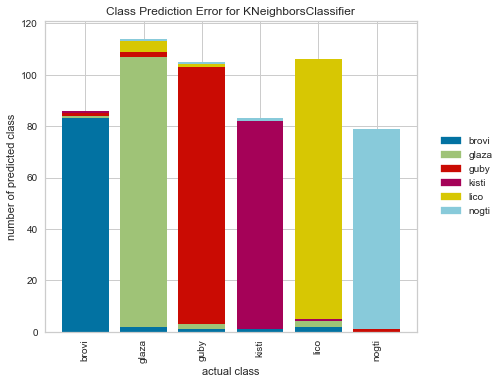

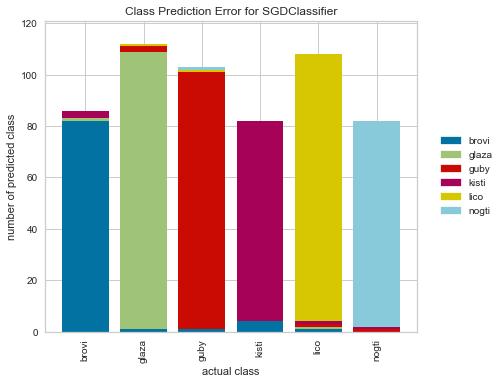

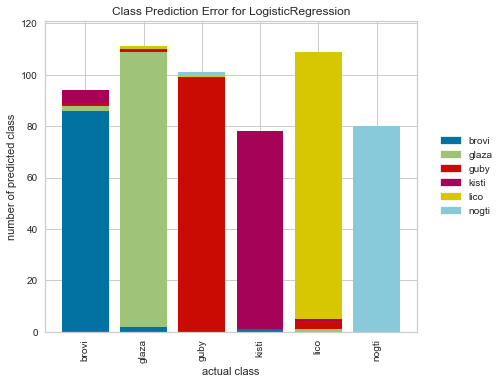

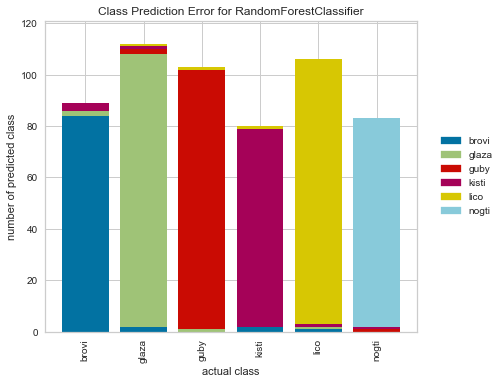

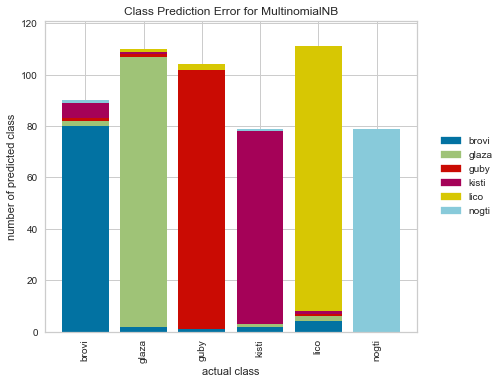

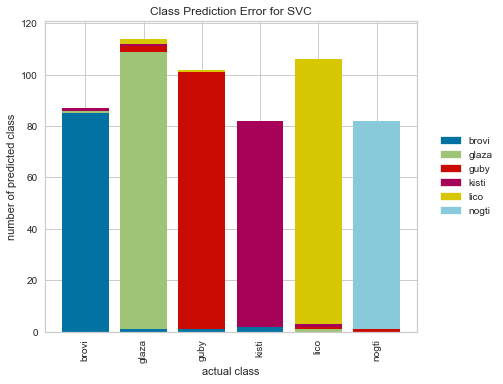

In [92]:
for model in models:
    model.best_estimator_.class_counts_ = 4
    visualizer = ClassPredictionError(
         model.best_estimator_, classes=labels, is_fitted=True
    )
    visualizer.score(data_test_vect, data_test_cat)
    visualizer.show()

Model: KNN


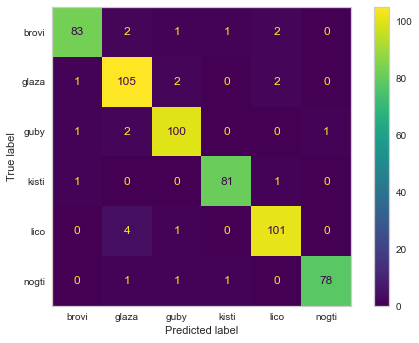

Model: SGD


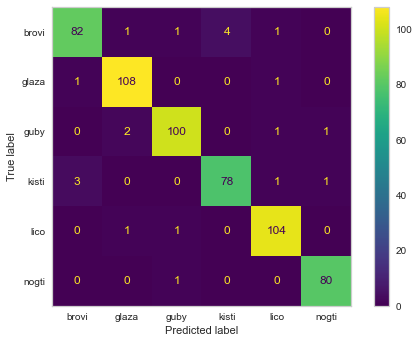

Model: Лог. регрессия


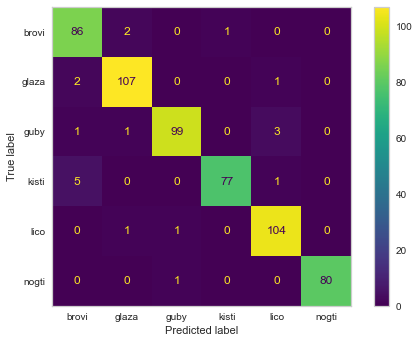

Model: Случайный лес


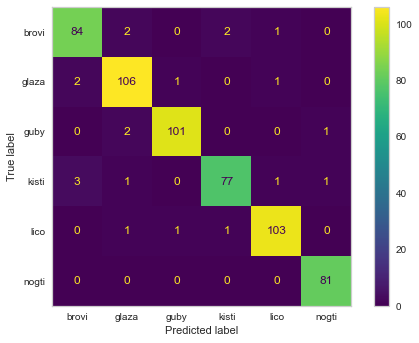

Model: Naive Bayes


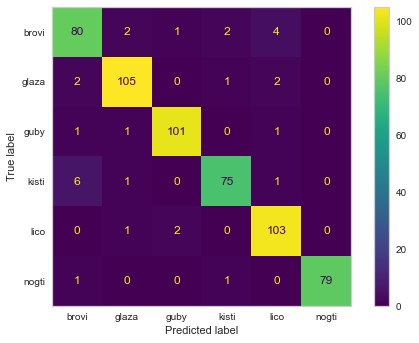

Model: SVC


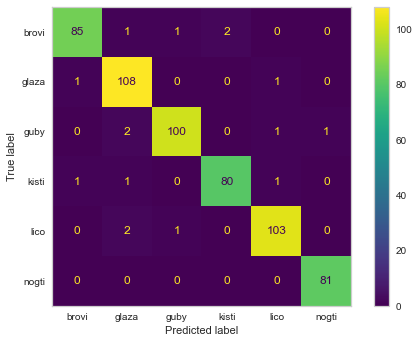

In [93]:
for name, pred in zip(names, preds):
    print(f"Model: {name}")
    metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(data_test_cat, pred),
                                   display_labels = labels).plot()
    plt.grid(False)
    plt.show()

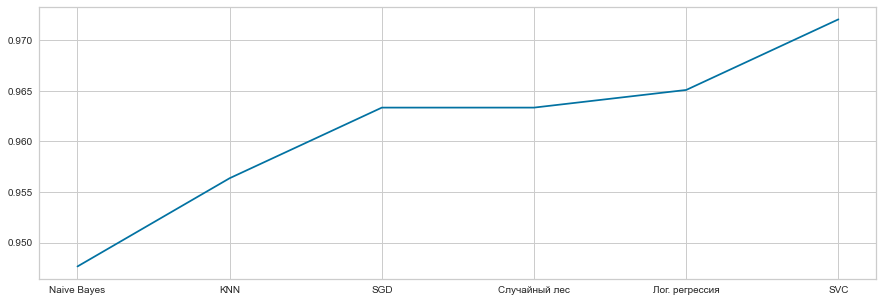

In [94]:
plt.figure(figsize=(15, 5))

acc, names_acc = zip(*sorted(zip([metrics.accuracy_score(data_test_cat, pred) for pred in preds], names)))

plt.grid(True)
plt.plot(names_acc, acc)

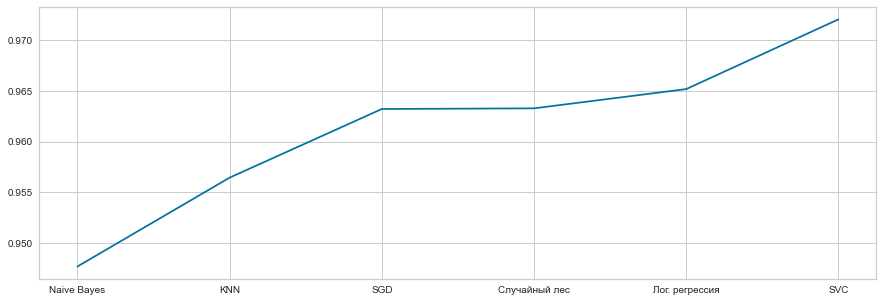

In [95]:
plt.figure(figsize=(15, 5))

f1s, names_f1 = zip(*sorted(zip([metrics.f1_score(data_test_cat, pred, average="weighted") for pred in preds], names)))

plt.grid(True)
plt.plot(names_f1, f1s)